<a href="https://colab.research.google.com/github/Shubham07102003/Celebal-summer-internship-2025/blob/main/WEEK-5/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# Name: Shubham
# Student Id: CT_CSI_DS_4356
#Assignment for Week-5
# Importing all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [38]:
# Load the data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
#sample_submission = pd.read_csv('sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()


Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [39]:
# @ Display data info and check for missing values
train.info()
train.describe()
train.isnull().sum().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageQual,81
GarageFinish,81
GarageType,81


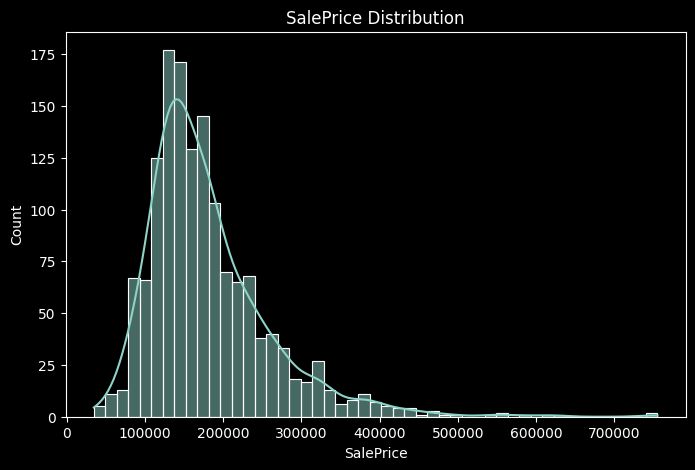

In [40]:
# @4. Exploratory Data Analysis (EDA)
# @4.1 Target Variable Analysis
plt.figure(figsize=(8,5))
sns.histplot(train['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.show()


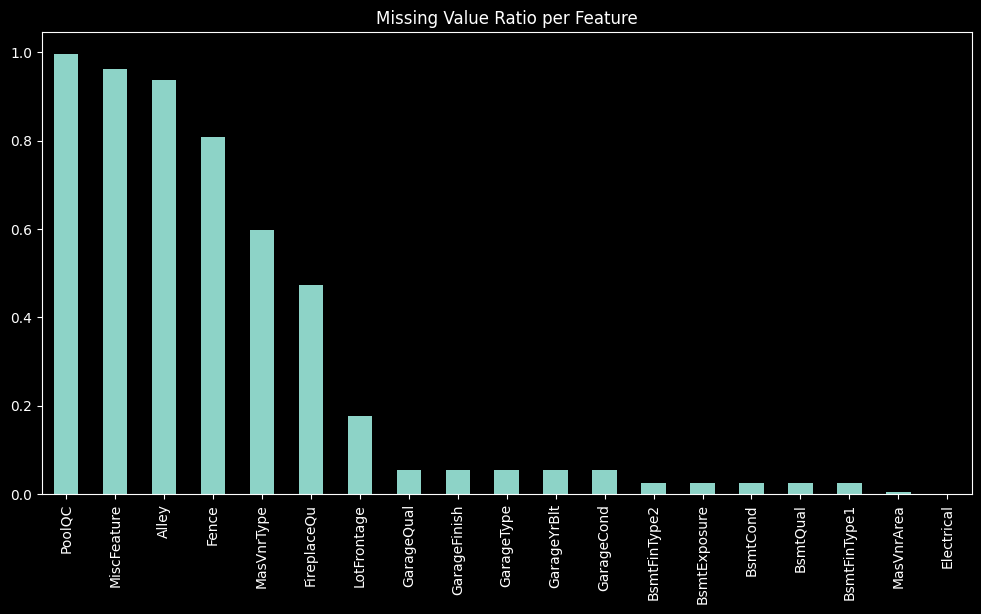

In [41]:
# @title 4.2 Missing Values Visualization
missing = train.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
missing[missing > 0].plot(kind='bar')
plt.title("Missing Value Ratio per Feature")
plt.show()


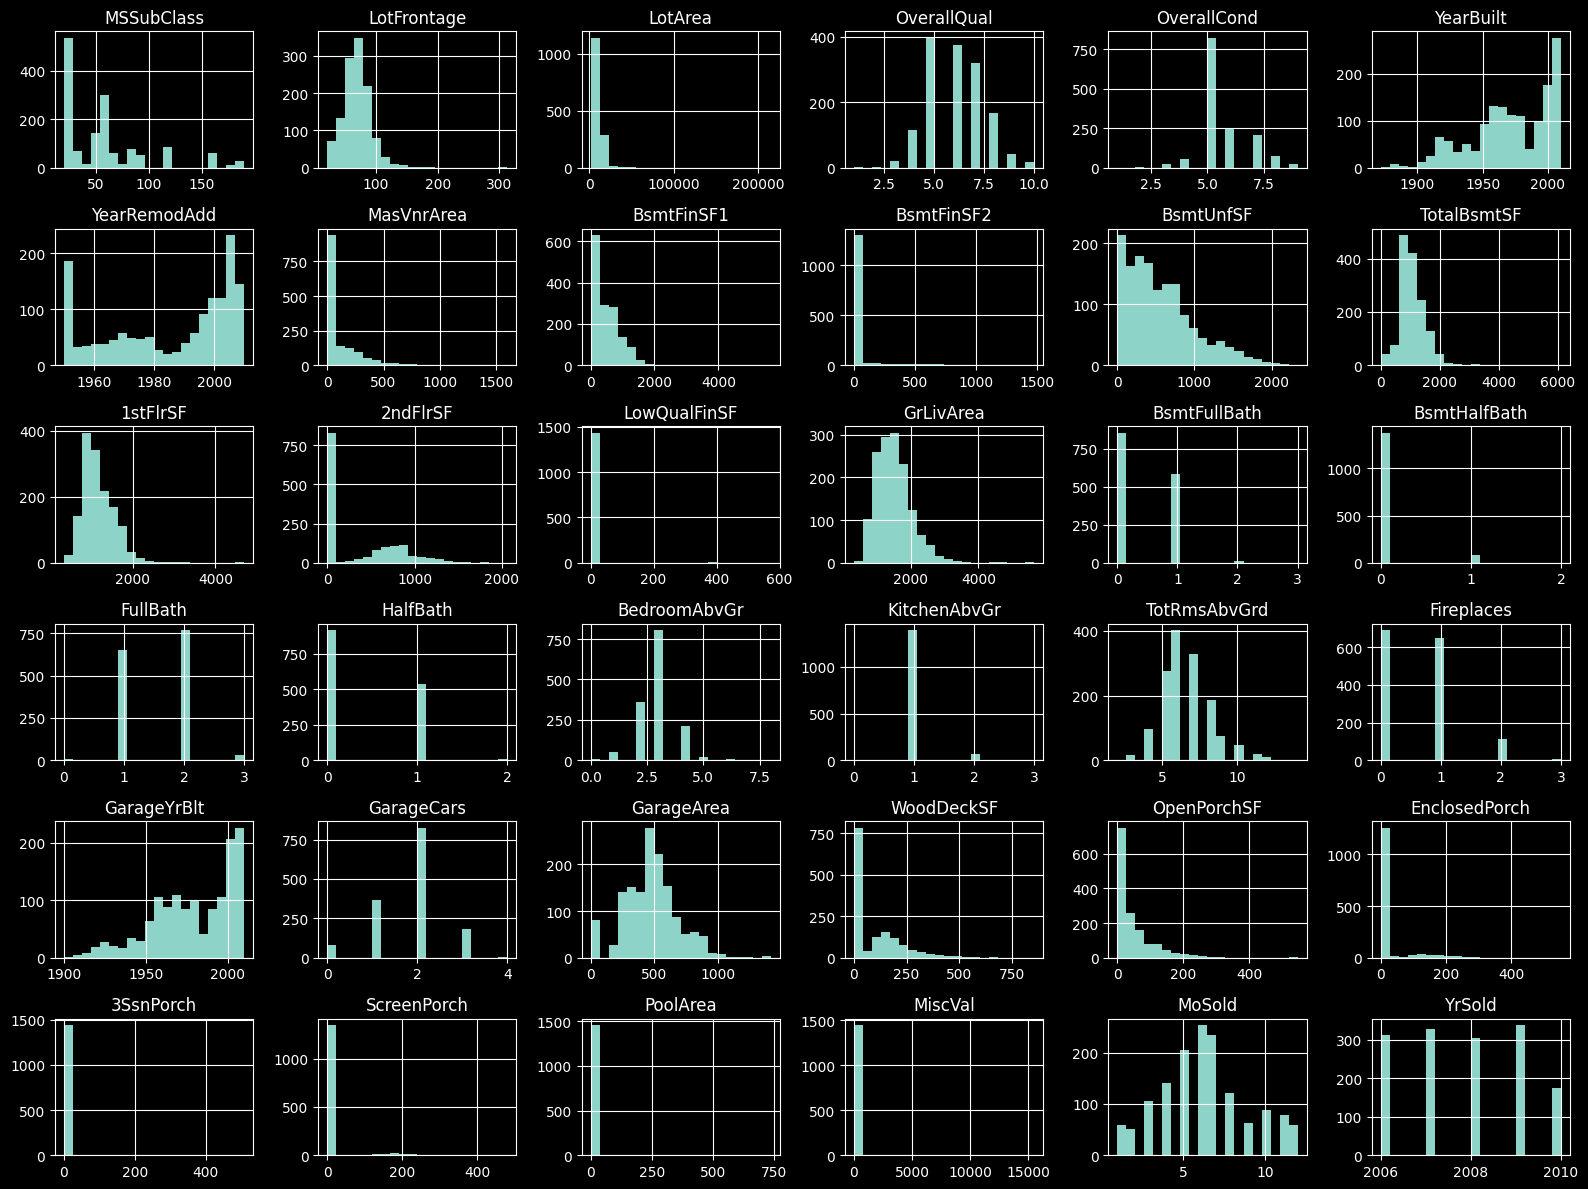

In [42]:
# @title 4.3 Numerical Feature Distributions
num_features = train.select_dtypes(include=[np.number]).columns.drop(['Id', 'SalePrice'])
train[num_features].hist(figsize=(16,12), bins=20)
plt.tight_layout()
plt.show()


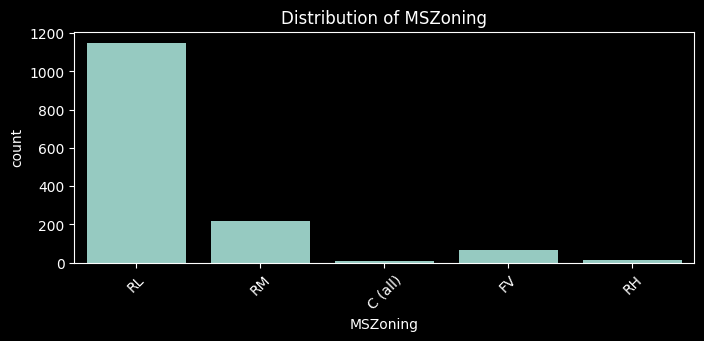

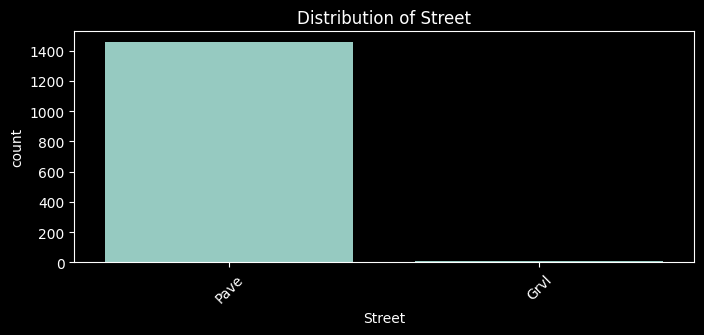

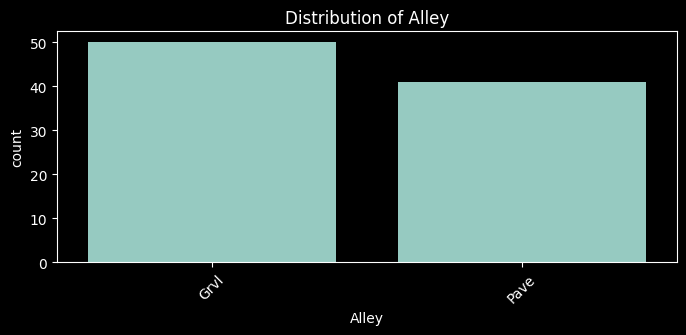

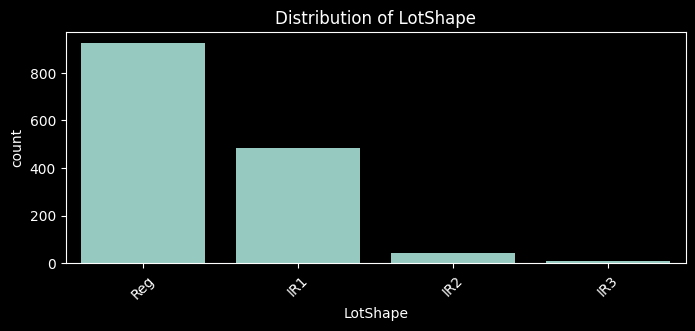

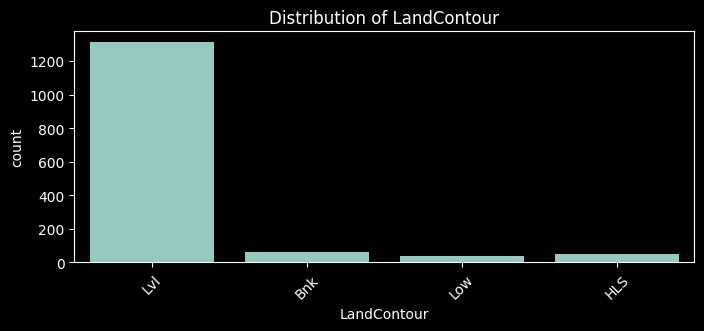

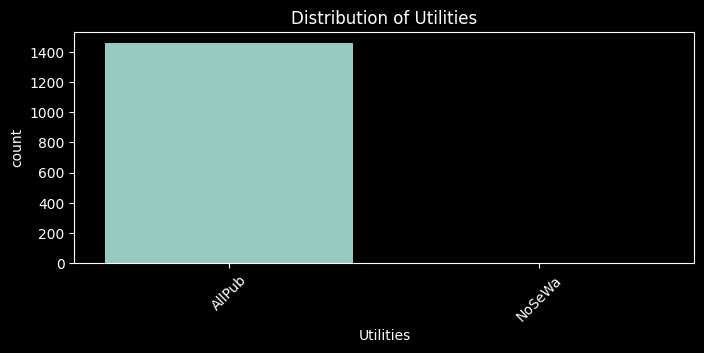

In [43]:
# @title 4.4 Categorical Feature Distributions
cat_features = train.select_dtypes(include=['object']).columns
for col in cat_features[:6]:
    plt.figure(figsize=(8,3))
    sns.countplot(x=col, data=train)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()


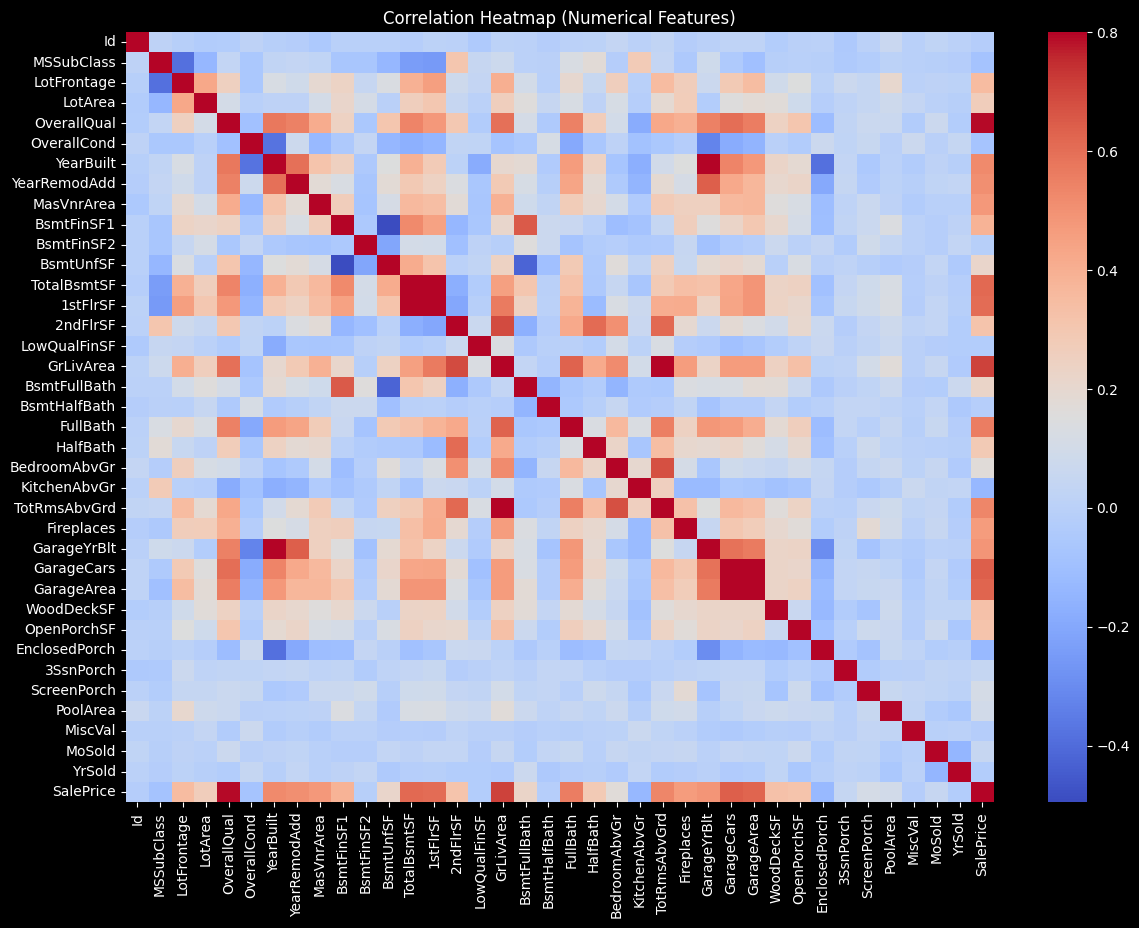

In [44]:
# @title 4.5 Correlation Heatmap (Numerical Features Only)

# Select only numeric columns
numeric_cols = train.select_dtypes(include=[np.number])

# Compute correlation matrix
corr = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap='coolwarm', vmax=0.8)
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()


In [45]:
# @title 5. Box Plot for Numerical Features

In [46]:
# @title 5.1 Handling Missing Values
# Impute numeric with median, categorical with 'None' for columns existing in both train and test

# Get the columns that are in both train and test (excluding 'SalePrice')
common_cols = [col for col in train.columns if col in test.columns]

for col in common_cols:
    if train[col].dtype == 'object':
        train[col] = train[col].fillna('None')
        test[col] = test[col].fillna('None')
    else:
        train[col] = train[col].fillna(train[col].median())
        test[col] = test[col].fillna(test[col].median())

# For 'SalePrice' in train, if needed (usually no missing values, but for completeness):
if train['SalePrice'].isnull().sum() > 0:
    train['SalePrice'] = train['SalePrice'].fillna(train['SalePrice'].median())



In [47]:
# @title 5.2 Log Transform Target
train['SalePrice'] = np.log1p(train['SalePrice'])


In [48]:
# @title 5.3 Feature Engineering
# Total square footage
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

# Age of the house
train['HouseAge'] = train['YrSold'] - train['YearBuilt']
test['HouseAge'] = test['YrSold'] - test['YearBuilt']


In [49]:
# @title 5.4 Encoding Categorical Variables
all_data = pd.concat([train.drop('SalePrice', axis=1), test], axis=0)
all_data = pd.get_dummies(all_data, drop_first=True)
X = all_data.iloc[:train.shape[0], :]
X_test = all_data.iloc[train.shape[0]:, :]
y = train['SalePrice']


In [50]:
# @title 5.5 Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)


In [51]:
# @title 6. Modeling: Regression Algorithms
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [52]:
# @title 6.1 Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [53]:
# @title 6.2 Simple Linear Regression
# Use only the most correlated feature (e.g., GrLivArea)

X_simple = X[['GrLivArea']].values
X_simple_scaled = scaler.fit_transform(X_simple)
X_tr, X_v, y_tr, y_v = train_test_split(X_simple_scaled, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_tr, y_tr)
y_pred = lr.predict(X_v)

simple_rmse = np.sqrt(mean_squared_error(y_v, y_pred))
simple_r2 = r2_score(y_v, y_pred)

print("Simple Linear Regression RMSE:", simple_rmse)
print("Simple Linear Regression R2:", simple_r2)

Simple Linear Regression RMSE: 0.29292748556653486
Simple Linear Regression R2: 0.5401851067339767


In [54]:
# @title 6.3 Multiple Linear Regression
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred = mlr.predict(X_val)

mlr_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mlr_r2 = r2_score(y_val, y_pred)

print("Multiple Linear Regression RMSE:", mlr_rmse)
print("Multiple Linear Regression R2:", mlr_r2)

Multiple Linear Regression RMSE: 0.17329986385183216
Multiple Linear Regression R2: 0.8390617667365551


In [55]:
# @title 6.4 Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

plr = LinearRegression()
plr.fit(X_poly, y_train)
y_pred = plr.predict(X_val_poly)

poly_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
poly_r2 = r2_score(y_val, y_pred)

print("Polynomial Regression RMSE:", poly_rmse)
print("Polynomial Regression R2:", poly_r2)


Polynomial Regression RMSE: 0.2130020921405786
Polynomial Regression R2: 0.7568744927653723


In [56]:
# @title 6.5 Ridge Regression
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_val)
ridge_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
ridge_r2 = r2_score(y_val, y_pred)
print("Ridge Regression RMSE:", ridge_rmse)
print("Ridge Regression R2:", ridge_r2)


Ridge Regression RMSE: 0.15521062151461099
Ridge Regression R2: 0.8709061175169841


In [57]:
# @title 6.6 Lasso Regression
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_val)

lasso_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
lasso_r2 = r2_score(y_val, y_pred)
print("Lasso Regression RMSE:", lasso_rmse)
print("Lasso Regression R2:", lasso_r2)


Lasso Regression RMSE: 0.15881430023189377
Lasso Regression R2: 0.8648419251789516


In [58]:
# @title 6.7 ElasticNet Regression
elastic = ElasticNet(alpha=0.001, l1_ratio=0.5)
elastic.fit(X_train, y_train)
y_pred = elastic.predict(X_val)

elastic_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
elastic_r2 = r2_score(y_val, y_pred)
print("ElasticNet Regression RMSE:", elastic_rmse)
print("ElasticNet Regression R2:", elastic_r2)


ElasticNet Regression RMSE: 0.15737642283962464
ElasticNet Regression R2: 0.8672782420099556


In [59]:
# @title 6.8 Decision Tree Regression
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)

dt_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
dt_r2 = r2_score(y_val, y_pred)
print("Decision Tree Regression RMSE:", dt_rmse)
print("Decision Tree Regression R2:", dt_r2)


Decision Tree Regression RMSE: 0.190725051697469
Decision Tree Regression R2: 0.8050701857374953


In [60]:
# @title 6.9 Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rf_r2 = r2_score(y_val, y_pred)
print("Random Forest Regression RMSE:", rf_rmse)
print("Random Forest Regression R2:", rf_r2)



Random Forest Regression RMSE: 0.149572855525737
Random Forest Regression R2: 0.880114031444352


In [61]:
# @title 6.10 Support Vector Regression
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred = svr.predict(X_val)

svr_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
svr_r2 = r2_score(y_val, y_pred)
print("Support Vector Regression RMSE:", svr_rmse)
print("Support Vector Regression R2:", svr_r2)



Support Vector Regression RMSE: 0.21000277376767043
Support Vector Regression R2: 0.7636732685274055


In [62]:
# @title 7. Model Comparison
# Collect RMSE and R2 for all models in a DataFrame for comparison
results = {
    'Simple Linear': [simple_rmse, simple_r2],
    'Multiple Linear': [mlr_rmse, mlr_r2],
    'Polynomial': [poly_rmse, poly_r2],
    'Ridge': [ridge_rmse, ridge_r2],
    'Lasso': [lasso_rmse, lasso_r2],
    'ElasticNet': [elastic_rmse, elastic_r2],
    'Decision Tree': [dt_rmse, dt_r2],
    'Random Forest': [rf_rmse, rf_r2],
    'SVR': [svr_rmse, svr_r2]
}

results_df = pd.DataFrame(results, index=['RMSE', 'R2']).T
results_df.sort_values('RMSE')


,RMSE,R2
Random Forest,0.149573,0.880114
Ridge,0.155211,0.870906
ElasticNet,0.157376,0.867278
Lasso,0.158814,0.864842
Multiple Linear,0.173300,0.839062
Decision Tree,0.190725,0.805070
SVR,0.210003,0.763673
Polynomial,0.213002,0.756874
Simple Linear,0.292927,0.540185


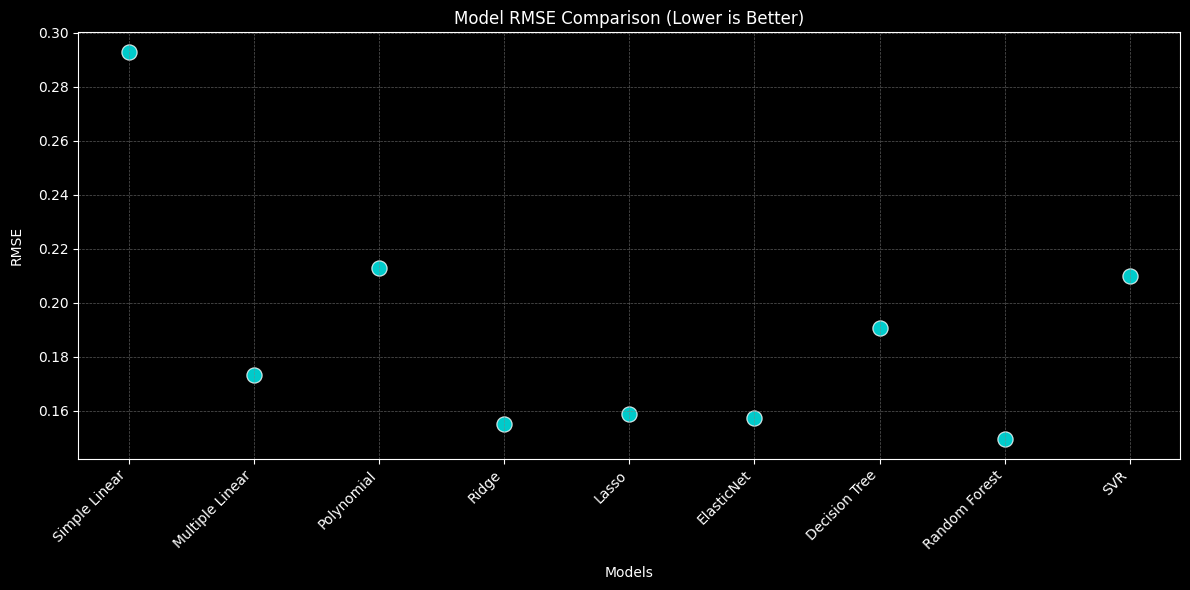

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

model_names = results_df.index.tolist()
rmses = results_df['RMSE'].tolist()

plt.figure(figsize=(12, 6))
plt.style.use('dark_background')

sns.scatterplot(x=model_names, y=rmses, color='cyan', alpha=0.8, s=120)
plt.xticks(rotation=45, ha='right')

plt.xlabel("Models", labelpad=10, color='white')
plt.ylabel("RMSE", labelpad=10, color='white')
plt.title("Model RMSE Comparison (Lower is Better)", color='white')
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


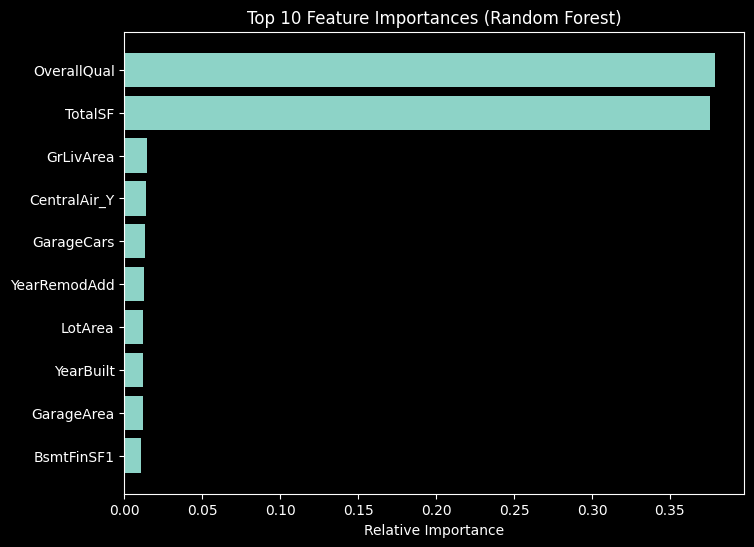

In [64]:
# @title 8. Feature Importance (Random Forest Example)
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [65]:
# @title 9. Prediction on Test Set and Submission
best_model = rf  # Or the model with best validation RMSE
test_preds = np.expm1(best_model.predict(X_test_scaled))

submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': test_preds})
submission.to_csv('submission.csv', index=False)
submission.head()


,Id,SalePrice
0,1461,122940.636327
1,1462,154748.764211
2,1463,169191.476341
3,1464,183581.324311
4,1465,205663.687298
